## Input and Output:

The input data is given by

* sd: A datetime object that represents the start date
* ed: A datetime object that represents the end date
* syms: A list of ticker symbols that make up the portfolio
* allocs: A list of allocations for the ticker symbols, the sum must be 1.0
* sv: Start value of the portfolio
* rfr: The constant risk free return per sample period
* sf: Sampling frequency per year
* gen_plot: If True produce plot, otherwise do not

The out data is given by

* cr: Cumulative return
* adr: Average period return (if sf == 252 this is daily return)
* sddr: Standard deviation of daily return
* sr: Sharpe ratio
* ev: End value of portfolio


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

### Setting up definitions:

In [5]:
def symbol_to_path(symbol, base_dir="data/"):
    """Return CSV file path given a corresponding ticker symbol."""
    return base_dir+"{}.csv".format(str(symbol))


def get_data(syms, dates):
    """Read stock data (adjusted close) for given symbols from CSV files. 
    Returns dataframe with SPY given automatically"""
    symbols = syms.copy()
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY': #dropping untraded days via SPY.
            df = df.dropna(subset=["SPY"])
    return df


def compute_periodic_returns(df,sf=252.0):
    """Returns the periodic returns given a period (sf) given by 252.0 (daily return)
    , 52.0 (weekly return) or 12.0 (monthly return)"""
    if sf == 252.0 :
        returns = df.copy()
        returns = (returns/returns.shift(1))-1.0
        returns.iloc[0] = 0
    if sf == 52.0 : 
        returns = df.copy()
        returns = returns.resample('W-FRI').sum()
        returns = (returns/returns.shift(1))-1.0
        returns.iloc[0] = 0
    if sf == 12.0 :
        returns = df.copy()
        returns = returns.resample('M').sum()
        returns = (returns/returns.shift(1))-1.0
        returns.iloc[0] = 0
    return returns


def compute_cumulative_returns(df):
    """Returns the cumulative return values"""
    cumret = df.copy()
    cumulative_return = cumret.iloc[-1]/cumret.iloc[0]-1.0
    return cumulative_return

def normalise(df):
    """Normalise the first date of to 1"""
    df = df/df.iloc[0]
    return df

def sharpe(port_val,rfr=0.0,sf=252.0):
    """Returns the periodic sharpe ratio"""
    dailyrfr = ((1.0 + rfr)**(1.0/sf))-1.0
    ret = compute_periodic_returns(port_val,sf)
    numerator = (ret-dailyrfr).mean()
    denominator = ret.std()
    S = (sf**(1./2))*numerator/denominator
    return S

def plot_data(df, title="Stock prices", ylabel = "Price", xlabel="Date"):
    """Returns plots of data"""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    plt.show()
    

### The assess_portfolio() method:

In [6]:
def assess_portfolio(sd=dt.datetime(2008,1,1), ed=dt.datetime(2009,1,1),
                     syms=['GOOG','AAPL','GLD','XOM'],
                     allocs=[0.1,0.2,0.3,0.4],
                     sv=1000000, rfr=0.0, sf=252.0,
                     gen_plot=True):
    """Returns a general assessment of portfolio - namely : cumulative return,
    average periodic return, standard deviation of the periodic return, sharpe ratio,
    final portfolio value (given initial investments)"""
    #SET UP: GETTING DATA - DELETE SPY AS WE USE IT AS A BENCHMARK
    symbols = syms.copy()
    dates = pd.date_range(sd,ed)
    df = get_data(syms,dates)
    if 'SPY' not in symbols: del df['SPY']
    
    #CLEANING
    if df.isnull().values.any() == True : 
        df.fillna(method="ffill", inplace="True")
        df.fillna(method="bfill", inplace="True")
        
    #SET UP: NORMALISATION
    df = normalise(df)

    #SET UP: BRING PORTFOLIO TOGETHER
    allocation = allocs*df
    pos_vals = allocation*sv
    port_val = pos_vals.sum(axis = 1)
    
    #CUMULATIVE RETURN
    cr = compute_cumulative_returns(port_val)
    
    #AVERAGE PERIOD RETURN
    adr = compute_periodic_returns(port_val,sf)
    mean_adr = adr.mean()
    sddr = adr.std()
    
    #SET UP: NORMALISED PORTFOLIO
    port_alloc = allocation.sum(axis=1)
    port_alloc = port_alloc.to_frame(name = 'Portfolio')
    if gen_plot==True:
        spy = get_data(['SPY'],dates)
        df = port_alloc.join(spy)
        df = normalise(df)
        plot_data(df)
    
    #SHARPE RATIO
    sr = sharpe(port_val,rfr,sf)
    #END VALUE OF PORTFOLIO
    ev = port_val[-1]
    
    print("Start Date: "+str(sd))
    print("End Date: "+str(ed))
    print("Symbols: "+str(symbols))
    print("Allocations: "+str(allocs))
    print("Sharpe Ratio: "+str(sr))
    print("Volatility (stdev of daily returns): "+str(sddr))
    print("Average Daily Return: "+str(mean_adr))
    print("Cumulative Return: " +str(cr))
    print ("Starting Portfolio Value:", sv)
    print ("Ending Portfolio Value:", ev)
    return cr,mean_adr,sddr,sr,ev

### Now we perform some analyses:

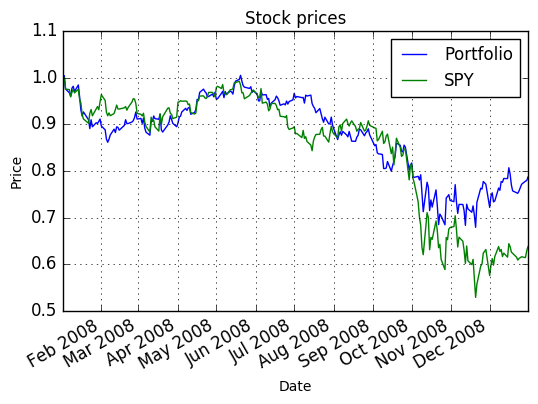

Start Date: 2008-01-01 00:00:00
End Date: 2009-01-01 00:00:00
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [0.1, 0.2, 0.3, 0.4]
Sharpe Ratio: -0.5746258041395982
Volatility (stdev of daily returns): 0.020460845561994442
Average Daily Return: -0.0007406421624781192
Cumulative Return: -0.213382409989
Starting Portfolio Value: 1000000
Ending Portfolio Value: 786617.590011


In [10]:
x = assess_portfolio()

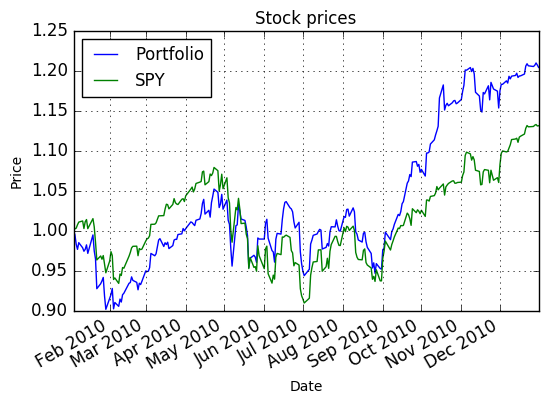

Start Date: 2010-01-01 00:00:00
End Date: 2010-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'IBM', 'XOM', 'SPY']
Allocations: [0.2, 0.3, 0.4, 0.05, 0.05]
Sharpe Ratio: 1.0724193614272277
Volatility (stdev of daily returns): 0.011980251833381179
Average Daily Return: 0.0008093387290509887
Cumulative Return: 0.204270492699
Starting Portfolio Value: 1000000
Ending Portfolio Value: 1204270.4927


In [11]:
x = assess_portfolio(sd=dt.datetime(2010,1,1), ed=dt.datetime(2010,12,31),
                         syms=['GOOG', 'AAPL', 'IBM', 'XOM','SPY'],
                         allocs = [0.2, 0.3, 0.4, 0.05,0.05]
                         ,sf=252.0)

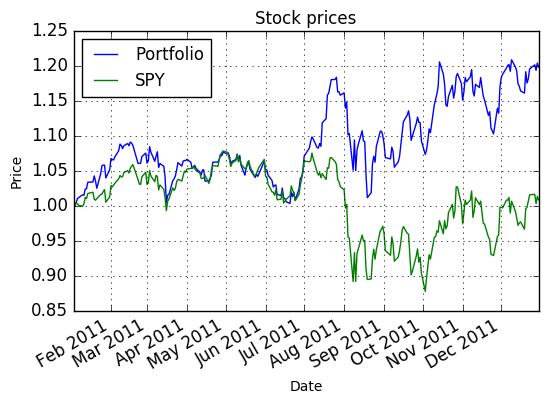

Start Date: 2011-01-01 00:00:00
End Date: 2011-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'IBM', 'XOM', 'SPY']
Allocations: [0.2, 0.3, 0.4, 0.05, 0.05]
Sharpe Ratio: 0.9639454391676757
Volatility (stdev of daily returns): 0.013267520114422863
Average Daily Return: 0.0008056416999510841
Cumulative Return: 0.1981941323
Starting Portfolio Value: 1000000
Ending Portfolio Value: 1198194.1323


In [16]:
x = assess_portfolio(sd=dt.datetime(2011,1,1), ed=dt.datetime(2011,12,31),
                         syms=['GOOG', 'AAPL', 'IBM', 'XOM','SPY'],
                         allocs = [0.2, 0.3, 0.4, 0.05,0.05]
                         ,sf=252.0)

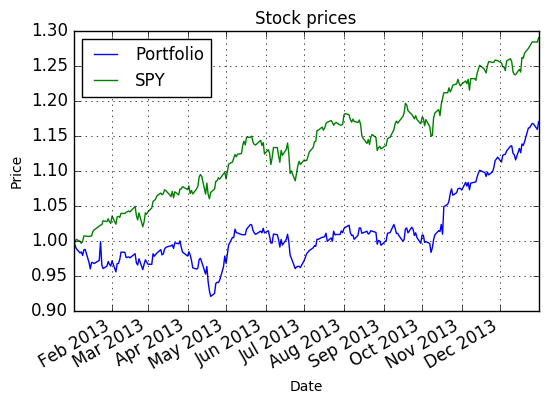

Start Date: 2013-01-01 00:00:00
End Date: 2013-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'IBM', 'XOM']
Allocations: [0.2, 0.3, 0.2, 0.2]
Sharpe Ratio: 1.2686636538501848
Volatility (stdev of daily returns): 0.008235314681899785
Average Daily Return: 0.0006581523347295175
Cumulative Return: 0.170348237139
Starting Portfolio Value: 1000000
Ending Portfolio Value: 1053313.41343


In [18]:
x = assess_portfolio(sd=dt.datetime(2013,1,1), ed=dt.datetime(2013,12,31),
                         syms=['GOOG', 'AAPL', 'IBM', 'XOM'],
                         allocs = [0.2, 0.3, 0.2,0.2]
                         ,sf=252.0)